# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob
from tqdm import tqdm
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [25]:
from data_transformation import CleanData
from features_library import FeatureTransformations
from regression import (
                        BaseReg,
                        RandomForestReg, 
                        HistGradientBoostingReg, 
                        SGDReg, 
                        ElasticNetReg, 
                        TheilSenReg,
                        RANSACReg
                        )
from trading_strategies import TradingStrategy
from performance_metrics import PerformanceMetrics

# Load Data

In [4]:
DIR_CRYPTO_DATA = "./data/1_Crypto_data/"
DIR_FINANCIAL_DATA = "./data/1_Financial_component_data/"

In [5]:
dict_assets = {}
ASSETS_SELECTED = [
    'BTC-USD',
    'ETH-USD',
    'XRP-USD',
    'LTC-USD',
]

for file_crypto in glob(f"{DIR_CRYPTO_DATA}*.csv"):

    # Read CSV
    asset_name = os.path.basename(file_crypto).split(".")[0]
    if not asset_name in ASSETS_SELECTED:
        continue
    df_asset = pd.read_csv(file_crypto)

    # Pre-Process Data
    preproc = CleanData(df_asset)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()

    # assign to dict
    dict_assets[asset_name] = preproc.df


In [6]:
dict_fd = {}
for file_fd in glob(f"{DIR_FINANCIAL_DATA}*.csv"):

    # Read CSV
    fd_name = os.path.basename(file_fd).split(".")[0]
    df_fd = pd.read_csv(file_fd)

    if fd_name.startswith("F-F"):
        df_fd = df_fd.loc[df_fd['Date']>19700101]
        df_fd["Date"] = df_fd["Date"].astype(str)
        df_fd["Date"] = df_fd["Date"].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    # Pre-Process Data
    preproc = CleanData(df_fd)
    preproc.make_datetime_index(date_col='Date')
    preproc.resample(freq='1D')
    preproc.strip_column_name()
    preproc.ffill()

    # Keep??
    # if ('Adj Close' not in df_fd.columns) and ('Close' in df_fd.columns):
    #     df_fd['Adj Close'] = df_fd['Close'].copy()

    # assign to dict
    dict_fd[fd_name] = preproc.df


In [7]:
df_risk_free = pd.read_excel(os.path.join(DIR_FINANCIAL_DATA, "RiskFree.xls"))
df_risk_free.index = df_risk_free['TcmDate']
df_risk_free.index.name = None
df_risk_free = df_risk_free[['Tcm1mo', 'Tcm3mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr']]
df_risk_free = df_risk_free.resample('1D').first().ffill()
df_risk_free

,Tcm1mo,Tcm3mo,Tcm1yr,Tcm5yr,Tcm10yr
1997-01-02,0.0519,0.0519,0.0563,0.0630,0.0654
1997-01-03,0.0517,0.0517,0.0560,0.0628,0.0652
1997-01-04,0.0517,0.0517,0.0560,0.0628,0.0652
1997-01-05,0.0517,0.0517,0.0560,0.0628,0.0652
1997-01-06,0.0517,0.0517,0.0561,0.0630,0.0654
...,...,...,...,...,...
2023-03-16,0.0422,0.0474,0.0449,0.0372,0.0356
2023-03-17,0.0431,0.0452,0.0426,0.0344,0.0339
2023-03-18,0.0431,0.0452,0.0426,0.0344,0.0339
2023-03-19,0.0431,0.0452,0.0426,0.0344,0.0339


# Feature Engineering

## Make Feature Transformations

For Assets, apply all feature transformations

In [8]:
for asset in dict_assets:
    feature_transformer = FeatureTransformations(dict_assets[asset])
    feature_transformer.transform_assets()
    dict_assets[asset] = feature_transformer.df_asset

For S&P500, apply selected feature transformations

In [9]:
dict_fd['S_P 500 index']['Volume'] = np.nan
# dict_fd['S_P 500 index'] = dict_fd['S_P 500 index'].ffill()
feature_transformer = FeatureTransformations(dict_fd['S_P 500 index'])
feature_transformer.transform_snp500()
dict_fd['S_P 500 index'] = feature_transformer.df_asset
dict_fd['S_P 500 index'].drop(columns=['Volume'], inplace=True)

## Add Financial Data to assets

In [10]:
for asset_name, df_asset in dict_assets.items():
    
    ASSET_START_PERIOD = df_asset.index.min()
    ASSET_END_PERIOD = df_asset.index.max()

    for financial_dataset, df_fd in dict_fd.items():

        df_fd = df_fd[ASSET_START_PERIOD:ASSET_END_PERIOD]
        
        rename_fd_cols = {column: f"{financial_dataset}_{column}".replace(" ", "_") for column in df_fd.columns}
        df_fd.rename(columns=rename_fd_cols, inplace=True)
        df_asset = pd.concat([df_asset, df_fd], axis=1)
    
    # add risk-free info
    df_asset = pd.concat([df_asset, df_risk_free[ASSET_START_PERIOD:ASSET_END_PERIOD]], axis=1)
    
    dict_assets[asset_name] = df_asset

## Normalize Features

In [11]:
# for asset_name, df_asset in dict_assets.items():
#     scaler = StandardScaler()
#     df_asset[df_asset.columns] = scaler.fit_transform(df_asset)
#     dict_assets[asset_name] = df_asset

# EDA Plots

## Describe Price Movements

Plot of close price trends with high-low indicators

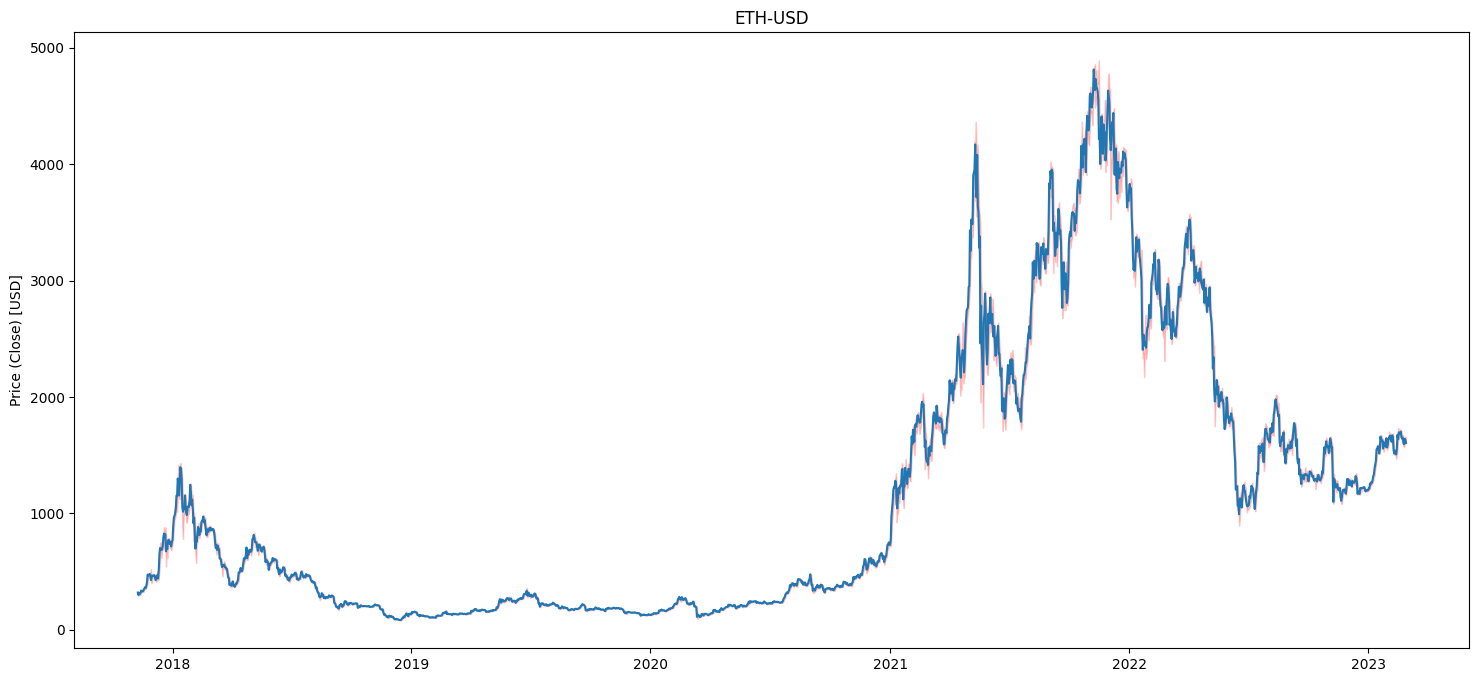

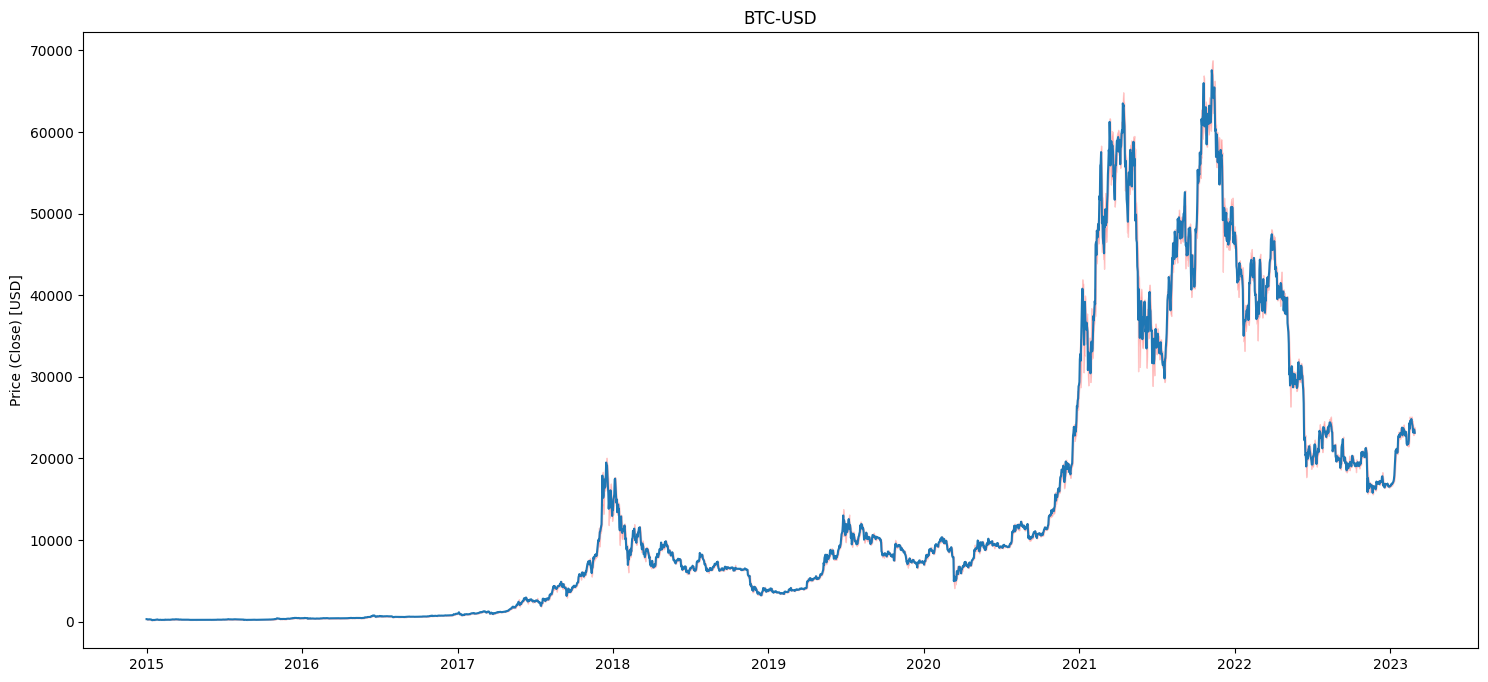

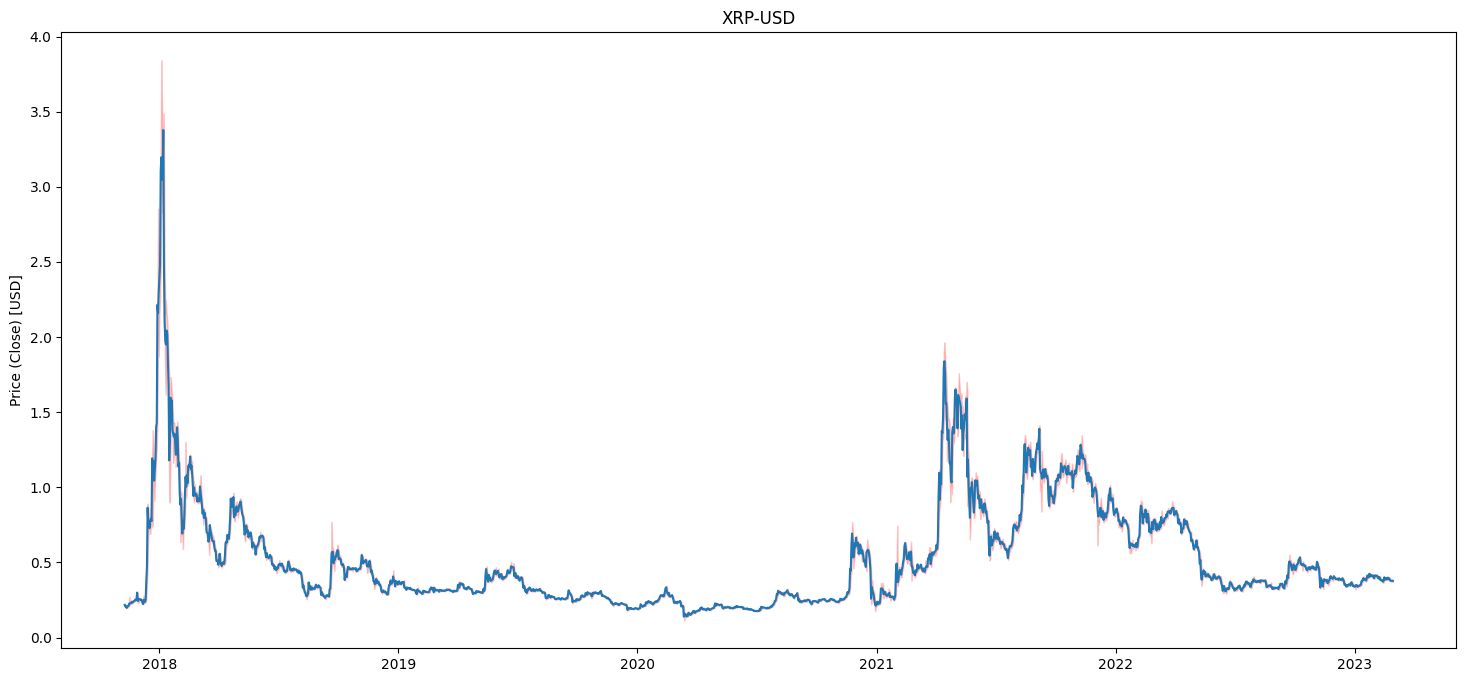

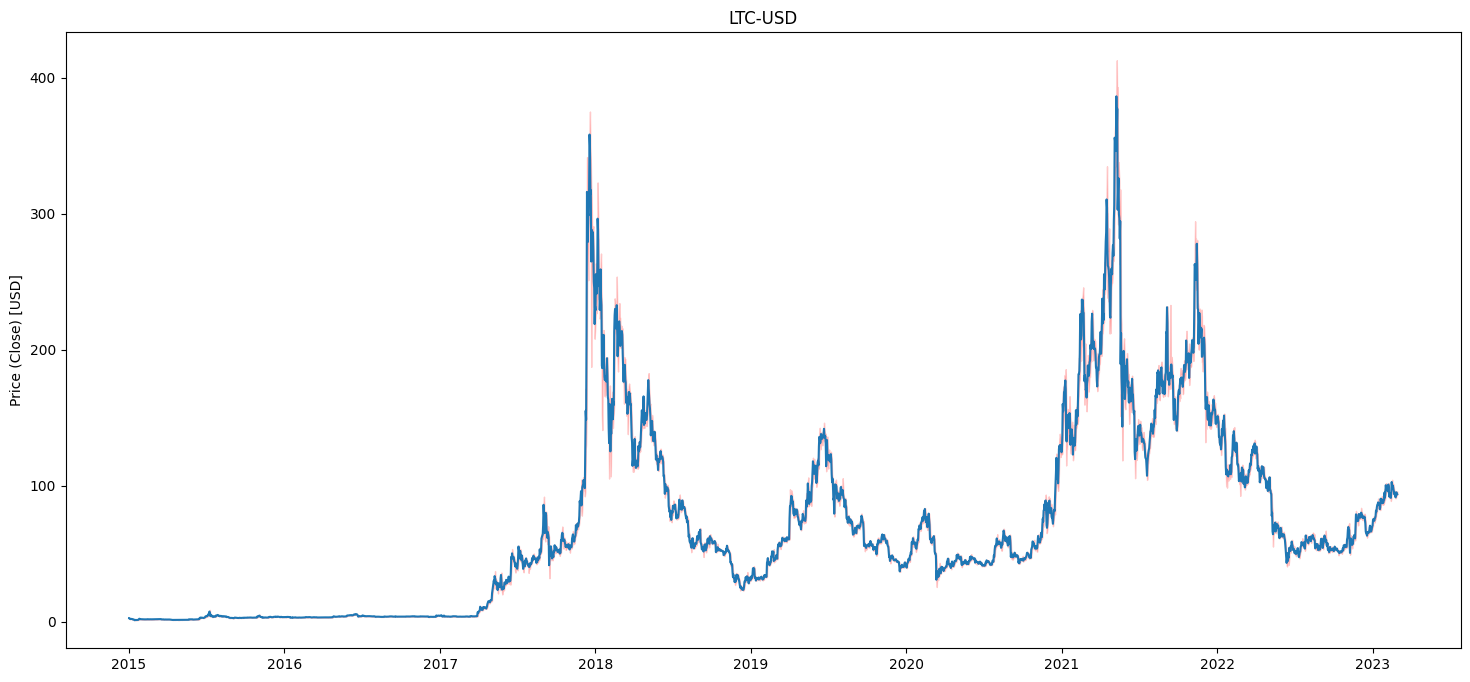

In [12]:
nrows = len(df_asset)
ncols = 1


for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 8))
    df_plot = df_asset#['2022-01-01': '2022-06-30']
    ax.plot(df_plot['Close'])

    ax.fill_between(
        df_plot.index, 
        df_plot['High'], 
        df_plot['Low'], 
        alpha=0.2,
        color='red',
        interpolate=False,
        )
    ax.set_title(asset_name)
    ax.set_ylabel("Price (Close) [USD]")
    
    plt.show()

Plot of close price trends of all assets

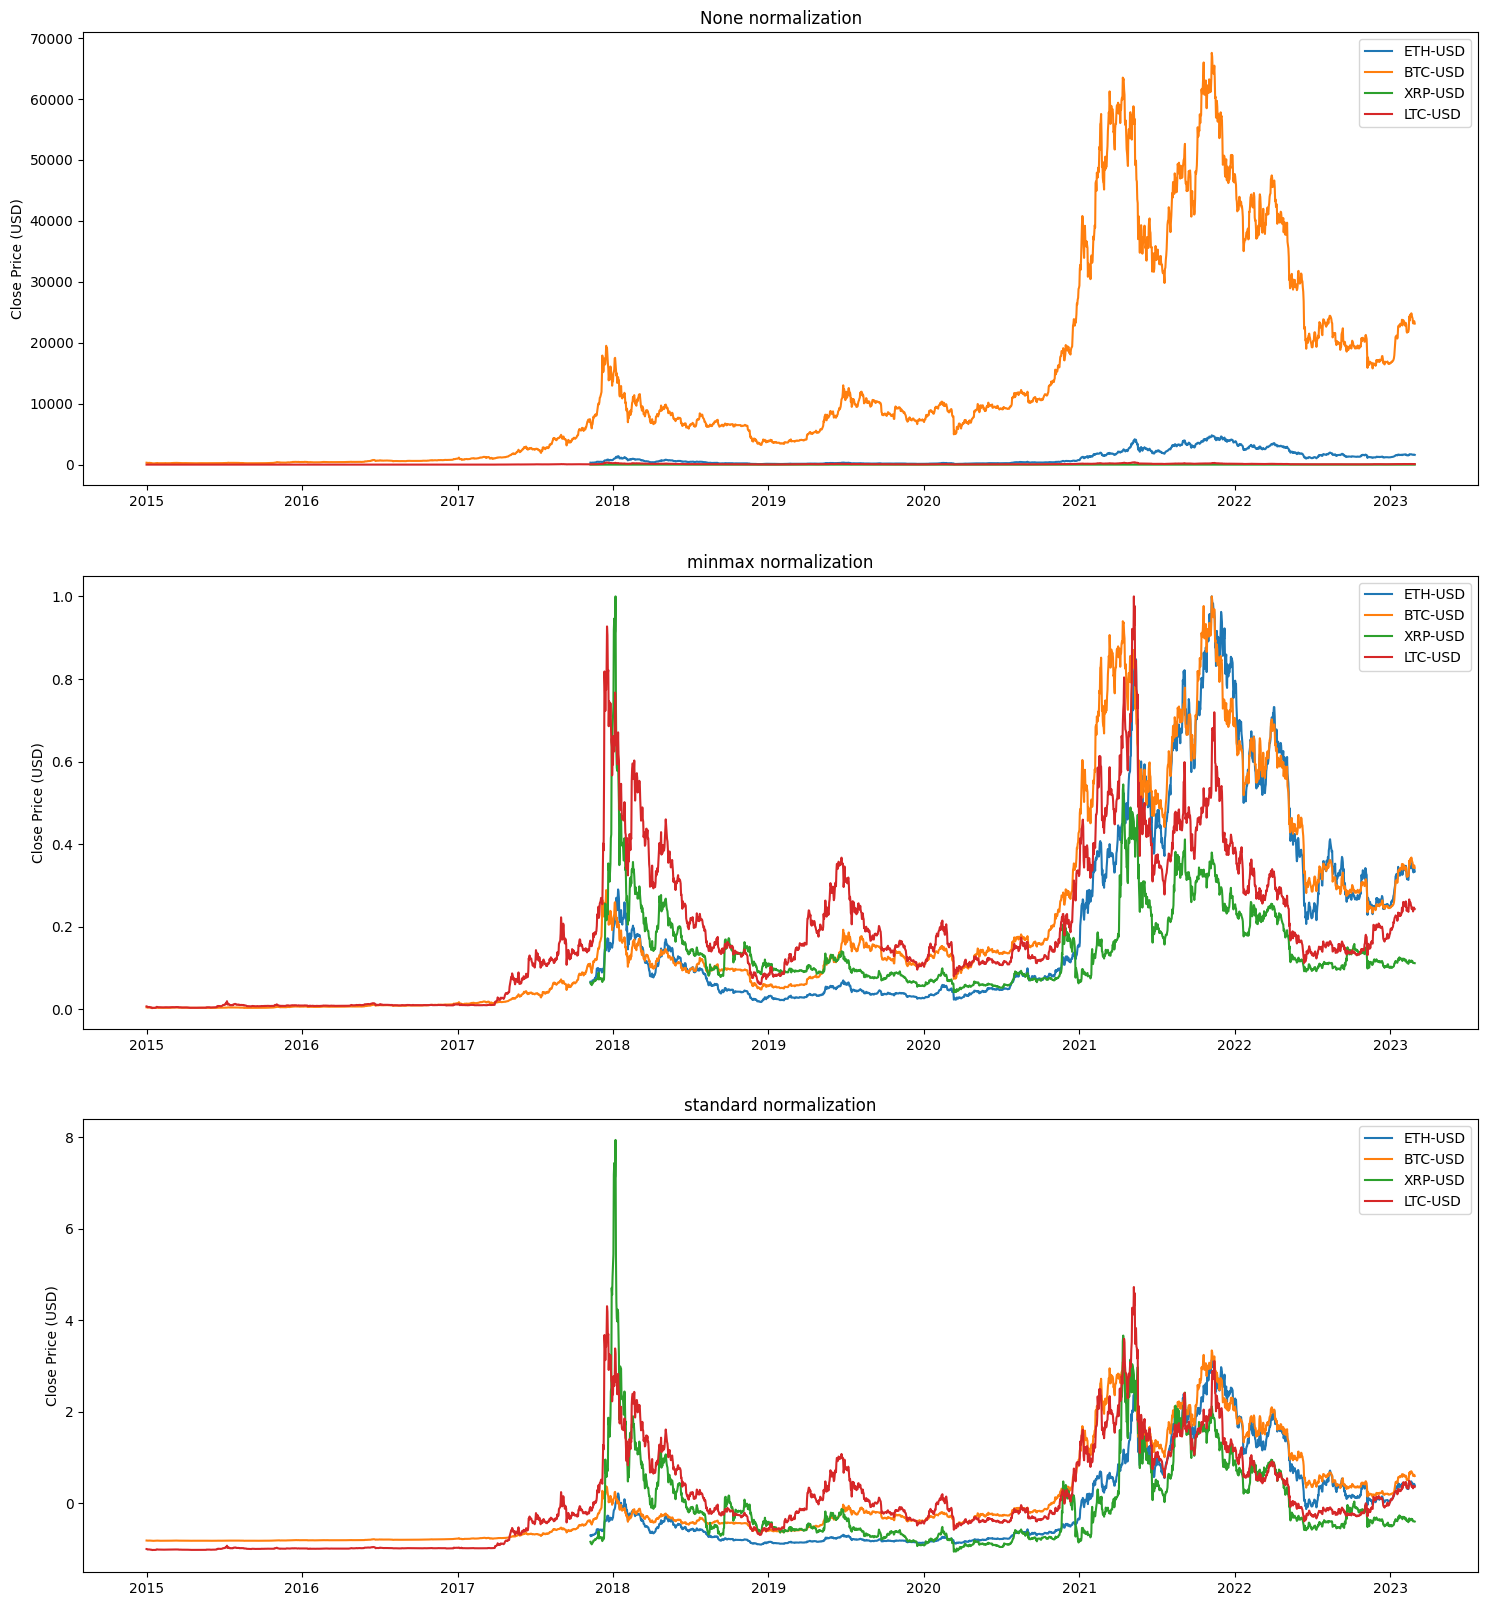

In [13]:
NORM = [None, 'minmax', 'standard']

nrows, ncols = len(NORM), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, (asset_name, df_asset) in enumerate(dict_assets.items()):
    # if asset_name == 'BTC-USD':
    #     continue
    df_plot = df_asset # ['2021-01-01':]
    for idx, norm_method in enumerate(NORM):
        ax = axs[idx]
        if norm_method==None:
            ax.plot(df_plot['Close'], label=asset_name)
        
        elif norm_method=='minmax':
            ax.plot(df_plot['Close']/df_plot['Close'].max(), label=asset_name)
        elif norm_method=='standard':
            standard_scaler = StandardScaler()
            ax.plot(
                pd.Series(
                    standard_scaler.fit_transform(df_plot['Close'].values.reshape(-1, 1)).reshape(1,-1)[0],
                    index=df_plot['Close'].index
                    ), 
                    label=asset_name)
        ax.set_title(f"{str(norm_method)} normalization")
        ax.set_ylabel(f"Close Price (USD)")
        ax.legend()

plt.show()

## Describe Returns

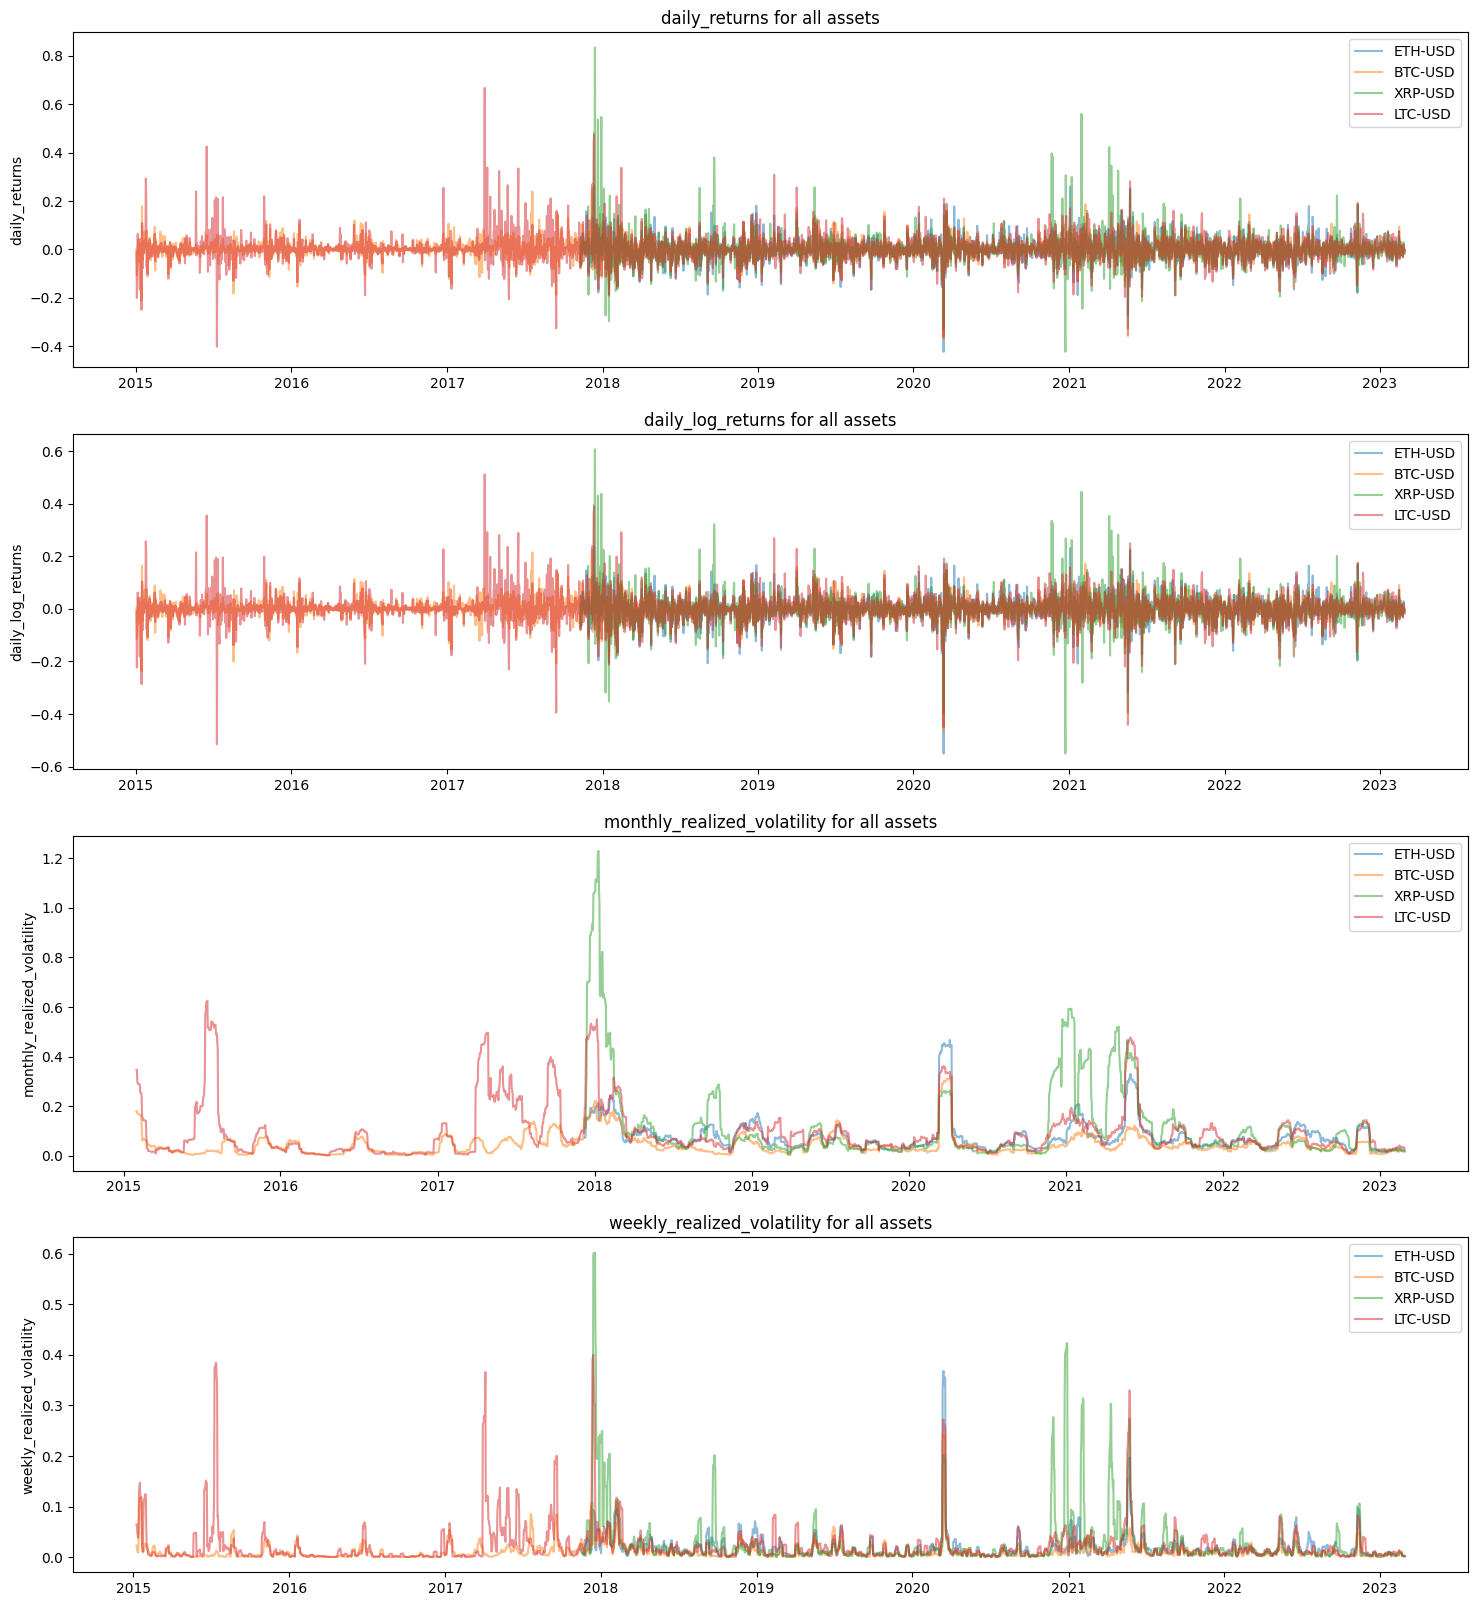

In [14]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    for asset_name, df_asset in dict_assets.items():
        # if asset_name == 'BTC-USD':
        #     continue
        df_plot = df_asset#['2021-01-01':]
        ax.plot(df_plot[return_var], label=asset_name, alpha=0.5)
        
    ax.set_title(f"{str(return_var)} for all assets")
    ax.set_ylabel(str(return_var))
    ax.legend(loc='upper right')
    
plt.show()

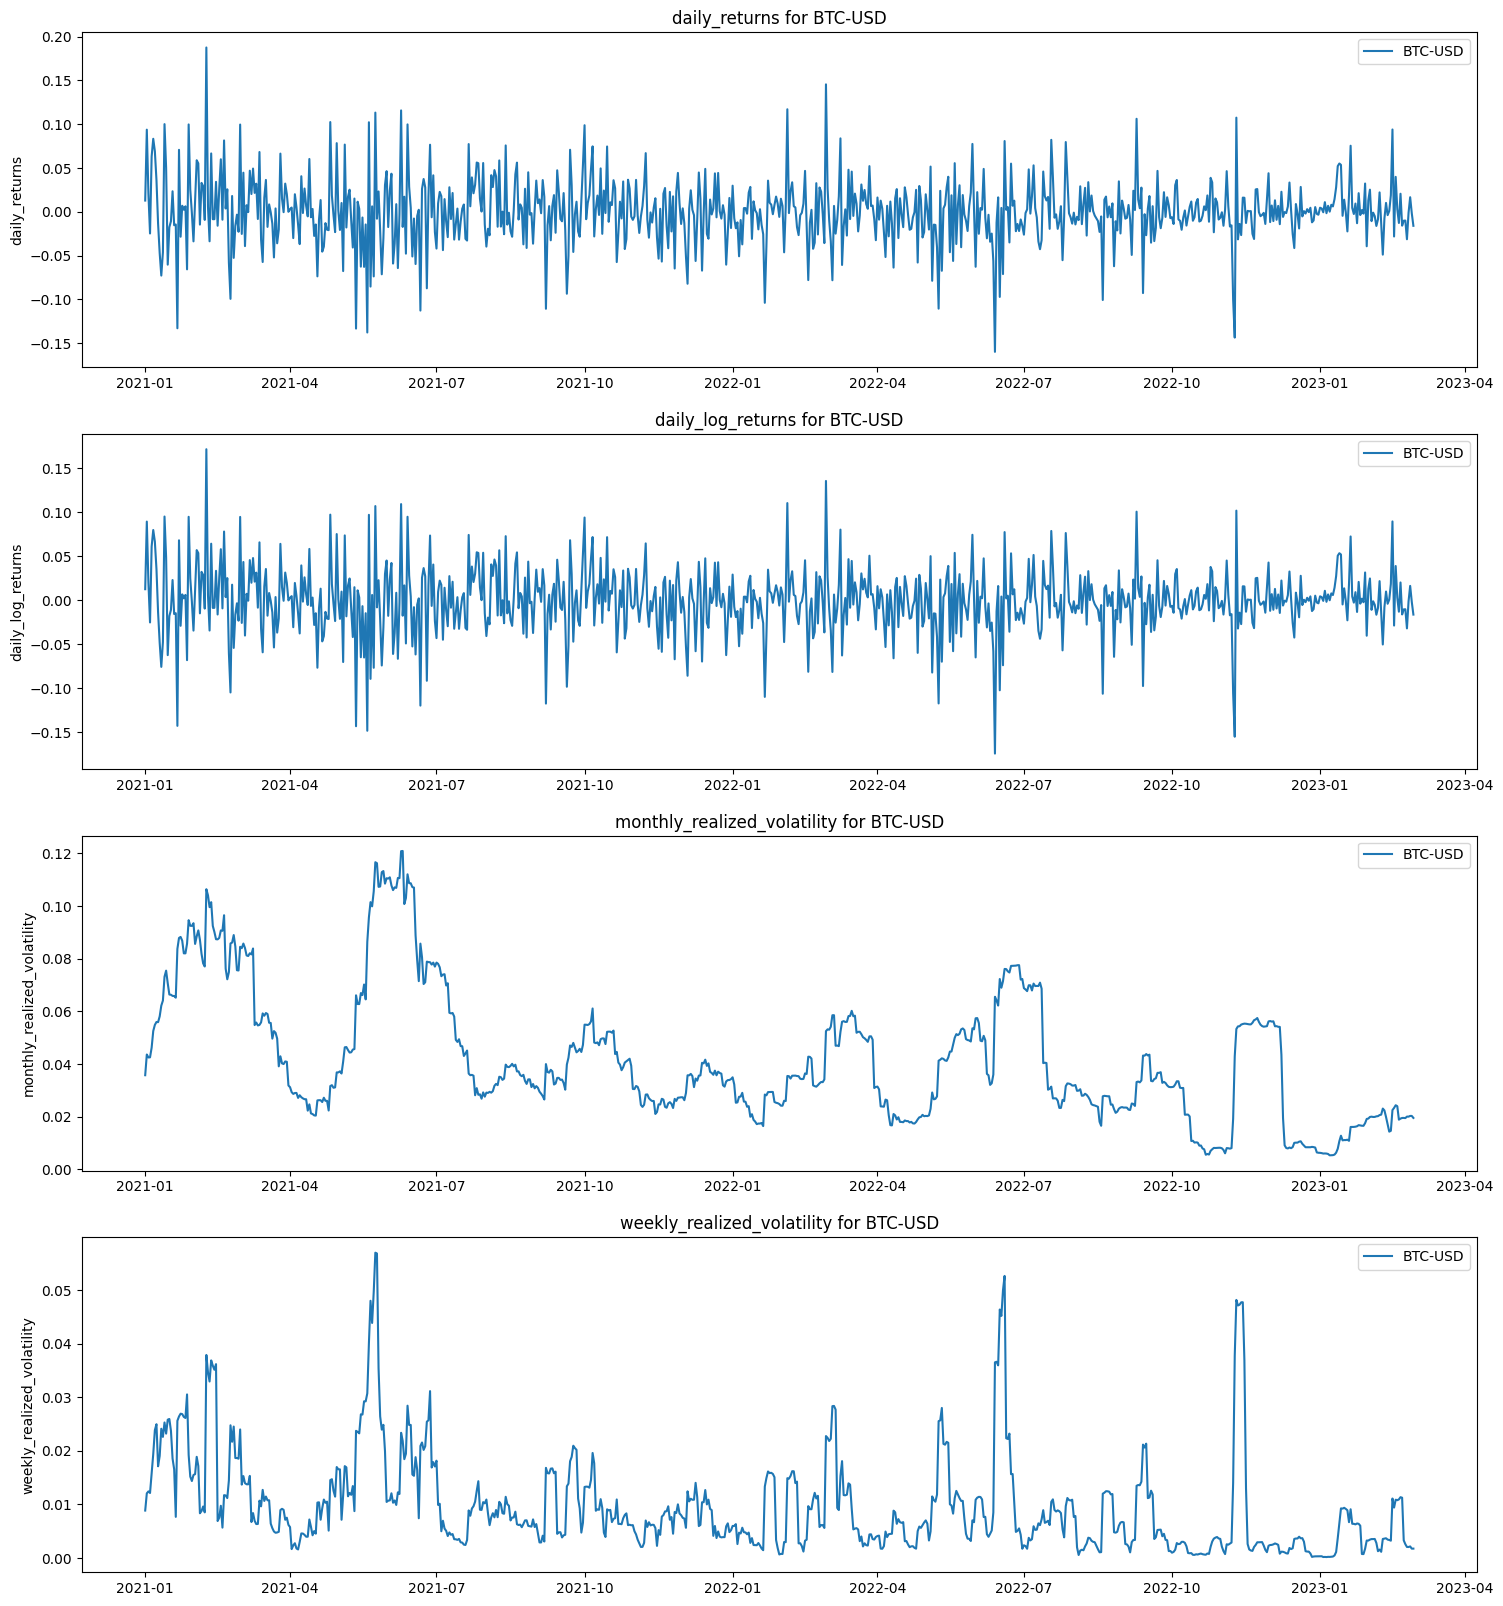

In [15]:
RETURN_VARS = ['daily_returns', 'daily_log_returns', 'monthly_realized_volatility', 'weekly_realized_volatility']
ASSET_NAME = 'BTC-USD'

nrows, ncols = len(RETURN_VARS), 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 20))

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(dict_assets)))
ax.set_prop_cycle('color', colors)

for idx, return_var in enumerate(RETURN_VARS):
    ax = axs[idx]
    df_asset = dict_assets[ASSET_NAME]
    df_plot = df_asset['2021-01-01':]
    ax.plot(df_plot[return_var], label=ASSET_NAME)

    ax.set_title(f"{str(return_var)} for {ASSET_NAME}")
    ax.set_ylabel(str(return_var))
    ax.legend()

plt.show()

## Correlation

Correlations between explanatory variables of each asset

In [26]:
df_asset = dict_assets['BTC-USD']

<Axes: >

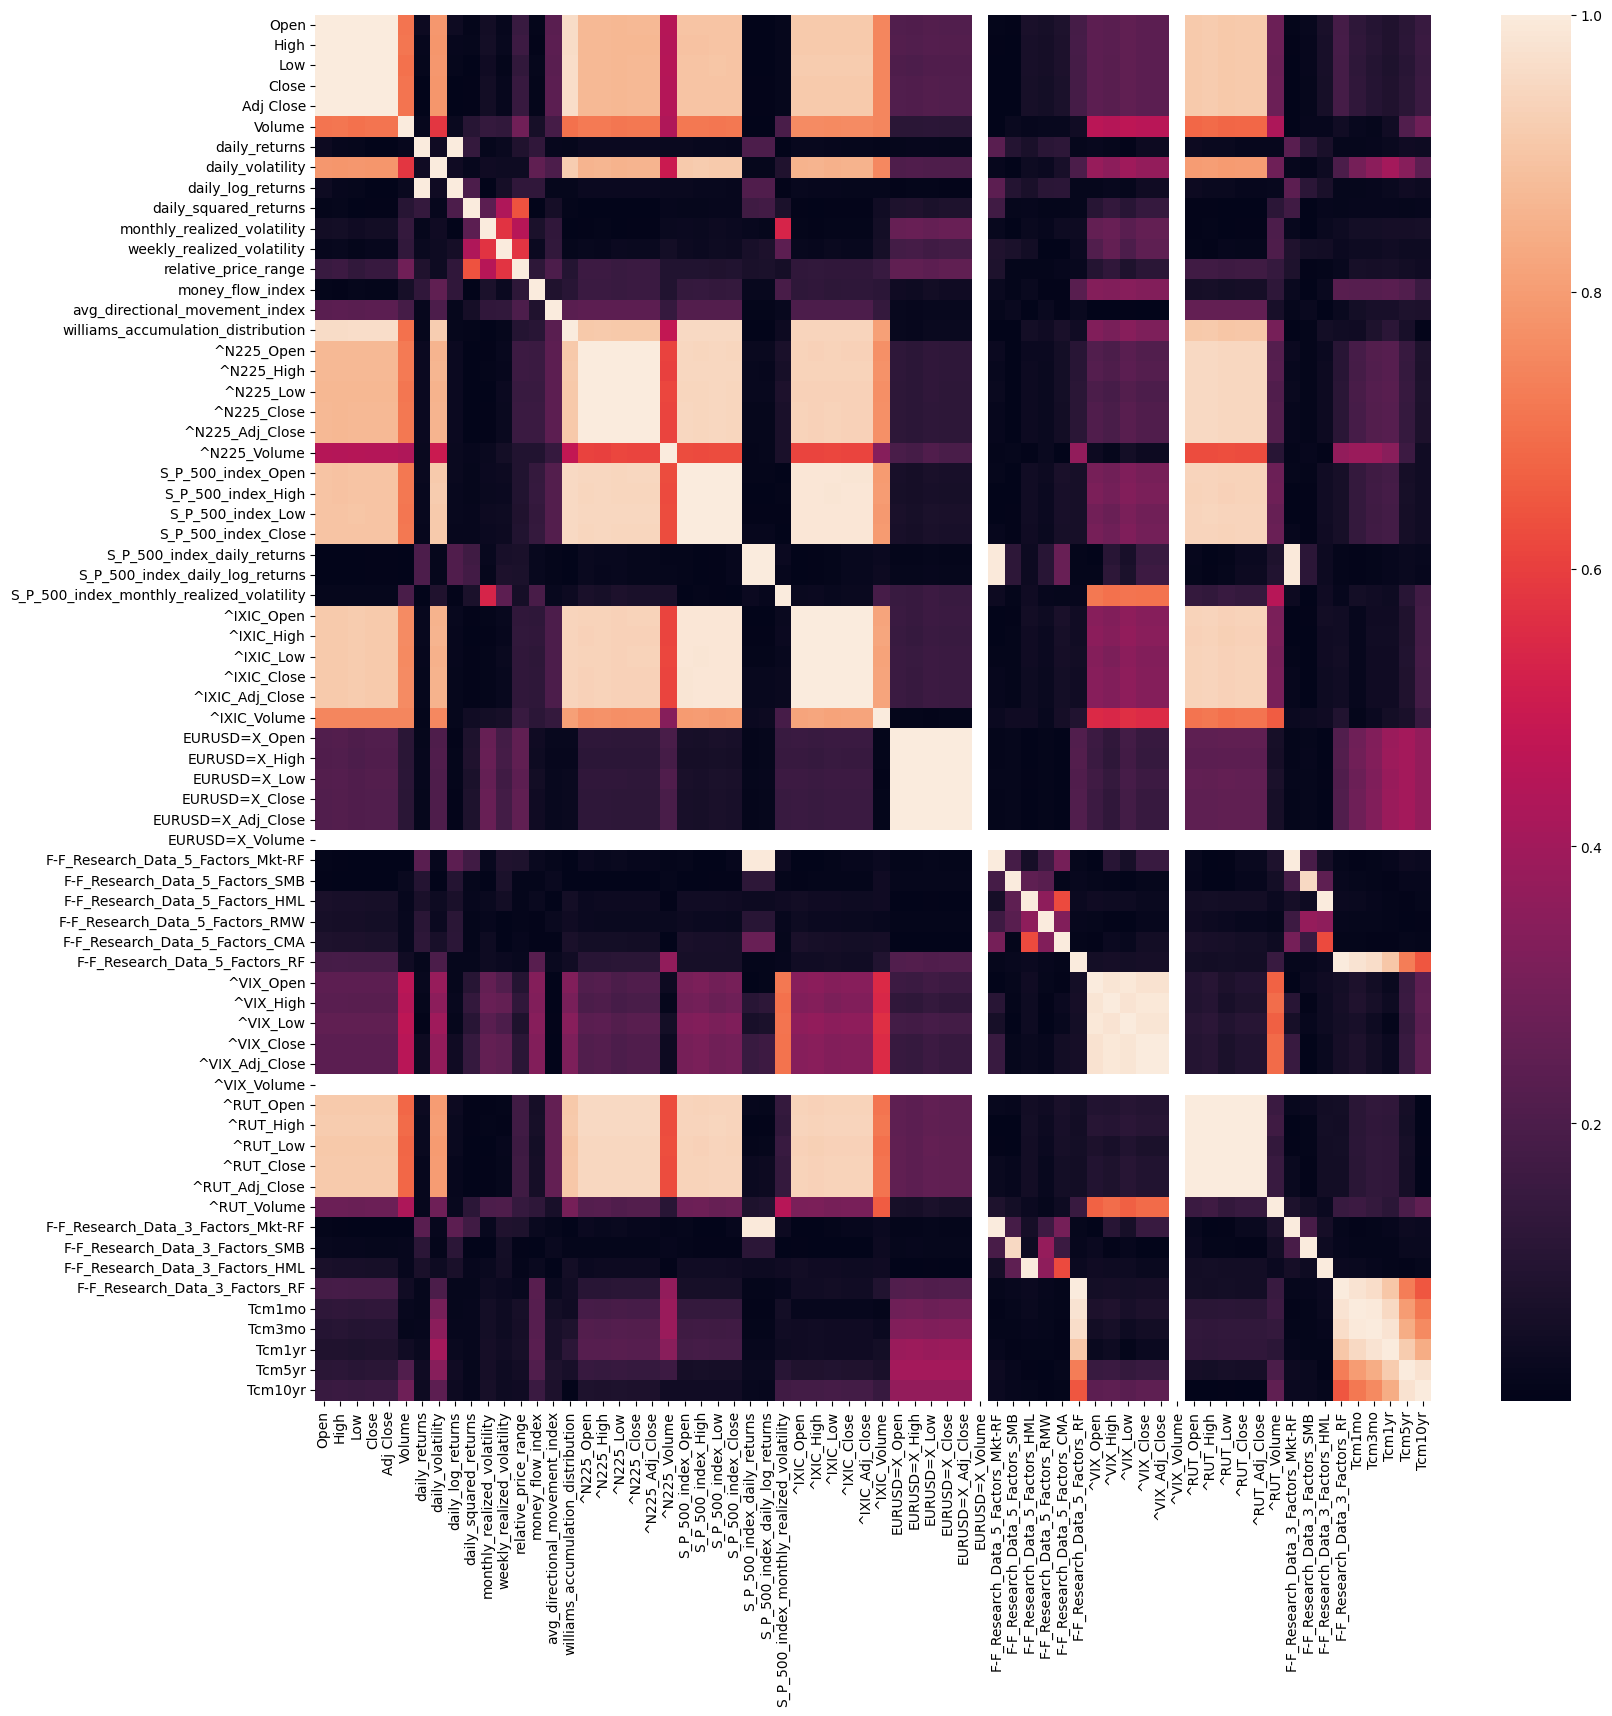

In [17]:
df_asset_corr = abs(df_asset['2015-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

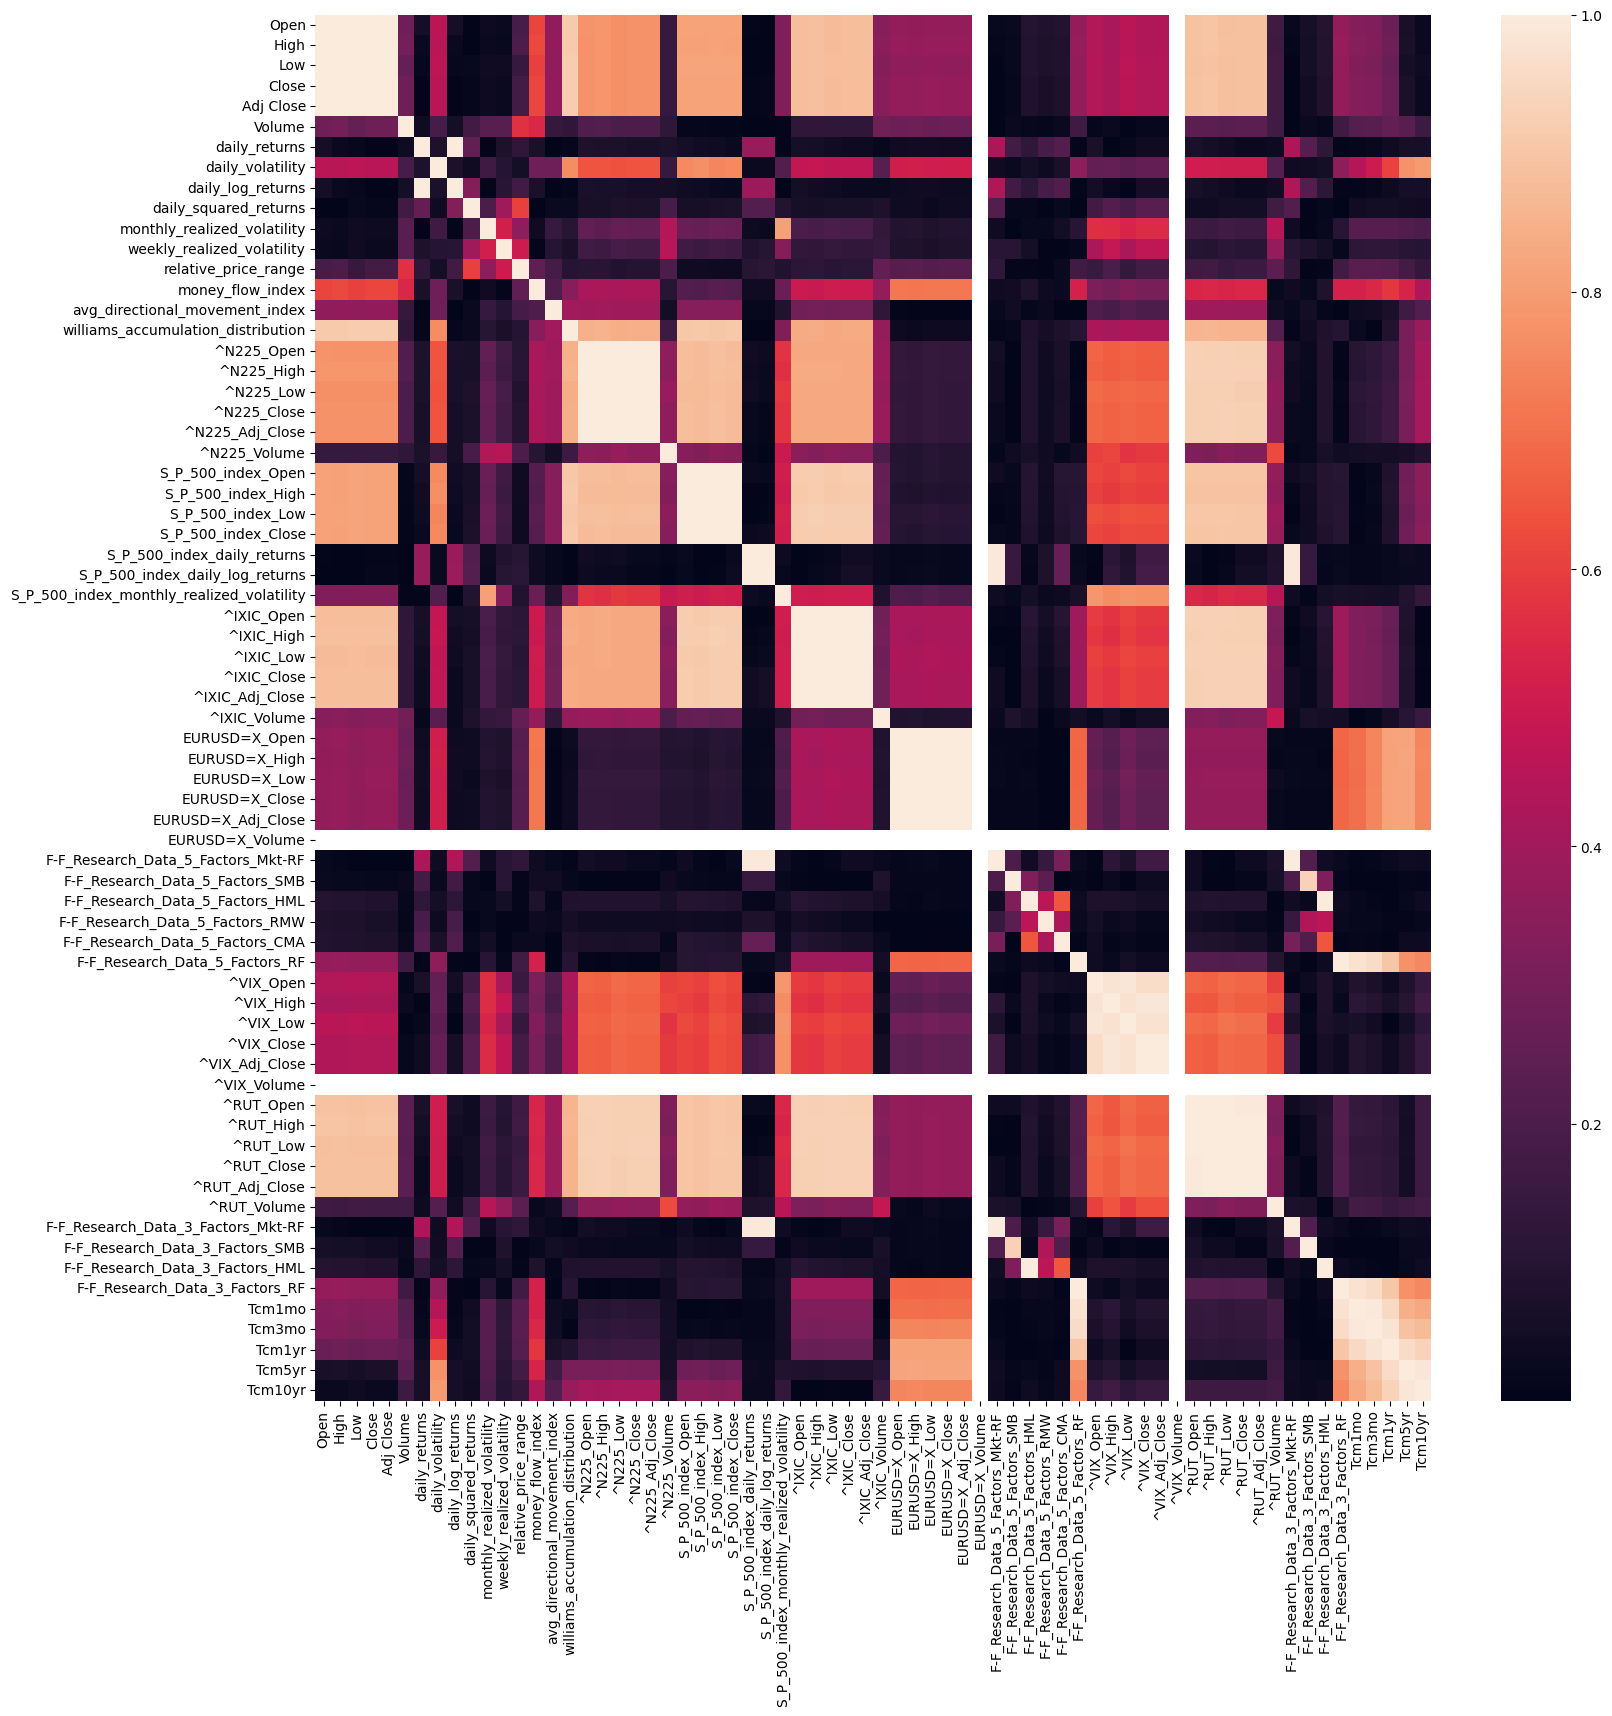

In [18]:
df_asset_corr = abs(df_asset['2020-01-01':].corr())

plt.figure(figsize=(18, 18))
sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    ax=plt.gca()
)

<Axes: >

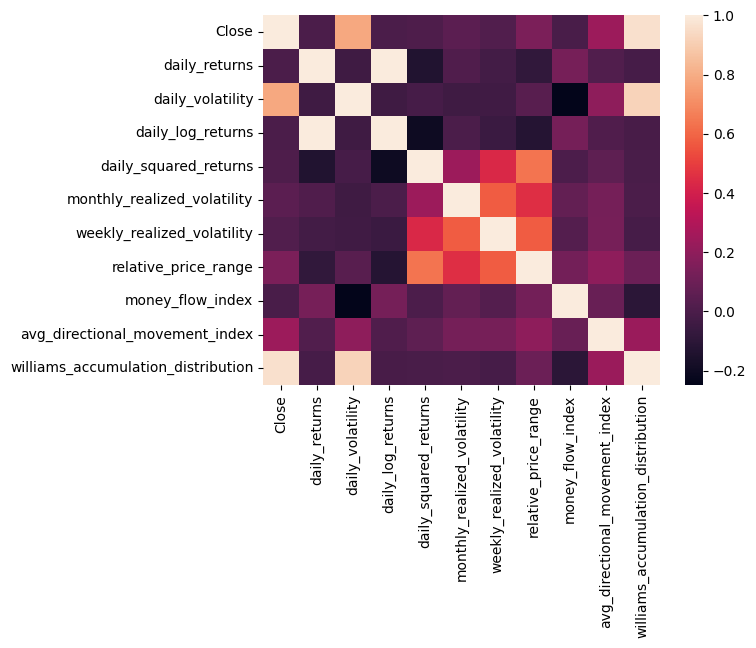

In [19]:
CALC_FEATS = [
    'daily_returns','daily_volatility', 'daily_log_returns', 'daily_squared_returns',
    'monthly_realized_volatility', 'weekly_realized_volatility', 'relative_price_range', 
    'money_flow_index', 'avg_directional_movement_index', 'williams_accumulation_distribution'
    ]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
)

<Axes: >

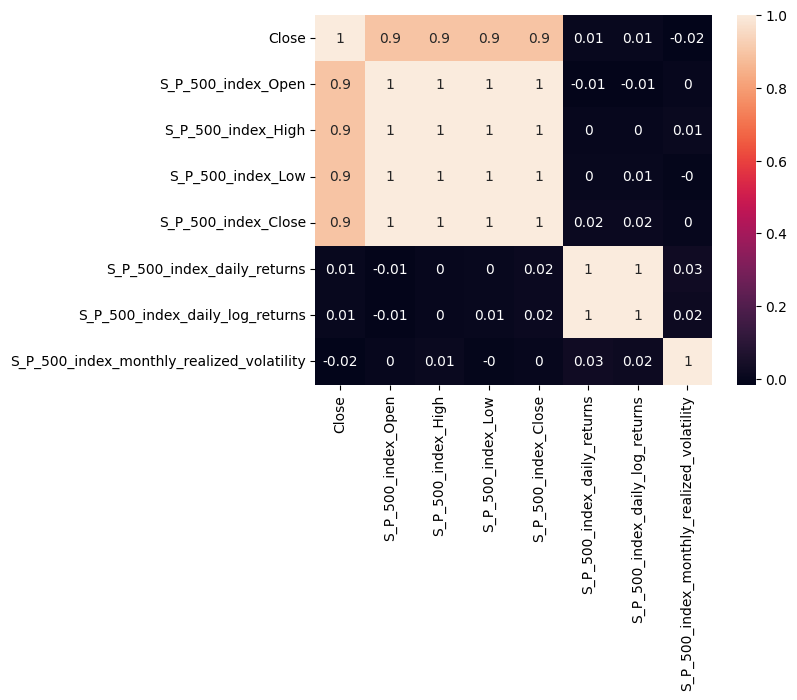

In [32]:
CALC_FEATS = [col for col in df_asset.columns if 'S_P_500' in col]

df_asset_corr = df_asset[['Close'] + CALC_FEATS].corr()

sns.heatmap(
    df_asset_corr,
    xticklabels=df_asset_corr.columns,
    yticklabels=df_asset_corr.columns,
    annot=np.round(df_asset_corr.values, 2),
)

<Axes: >

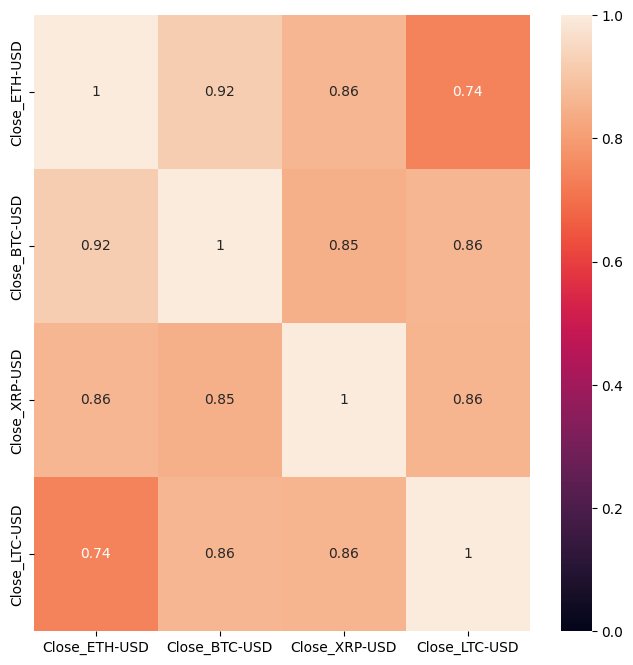

In [21]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2019-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

<Axes: >

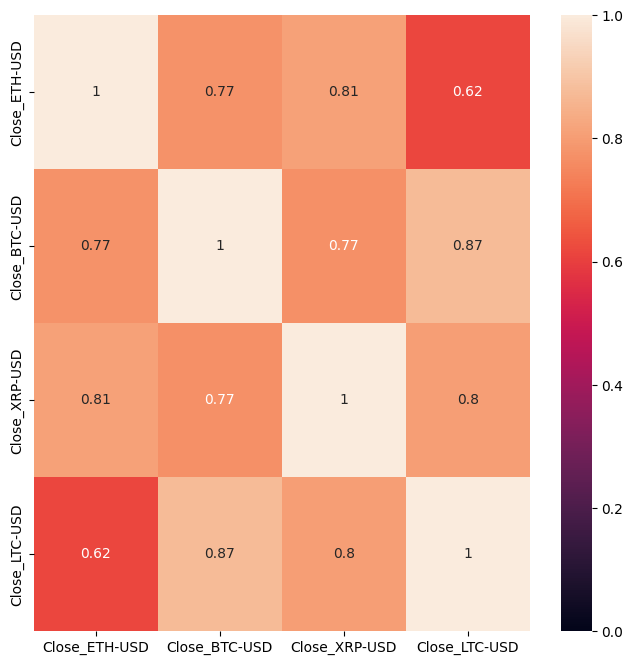

In [22]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)


TIME_PERIOD_START = '2021-01-01'
TIME_PERIOD_END = None #'2023-01-01'

if TIME_PERIOD_START:
    df_close_all_assets = df_close_all_assets[TIME_PERIOD_START:]
if TIME_PERIOD_END:
    df_close_all_assets = df_close_all_assets[:TIME_PERIOD_END]

df_all_asset_corr = df_close_all_assets.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    df_all_asset_corr,
    xticklabels=df_all_asset_corr.columns,
    yticklabels=df_all_asset_corr.columns,
    annot=df_all_asset_corr.values,
    ax=plt.gca(),
    vmin=0,
)

In [23]:
df_close_btc_eth = pd.concat(
    [
        dict_assets['BTC-USD']['Close'].rename("Close_BTC-USD"), 
        dict_assets['ETH-USD']['Close'].rename("Close_ETH-USD"), 
    ], 
    axis=1,
)
df_close_btc_eth = df_close_btc_eth.dropna()
df_close_btc_eth = df_close_btc_eth.resample('1D').first()

corr_btc_eth_mean = pearsonr(df_close_btc_eth['Close_BTC-USD'], df_close_btc_eth['Close_ETH-USD']).statistic
corr_btc_eth_60d_roll = df_close_btc_eth['Close_BTC-USD'].rolling('60D', min_periods=60).corr(df_close_btc_eth['Close_ETH-USD'])

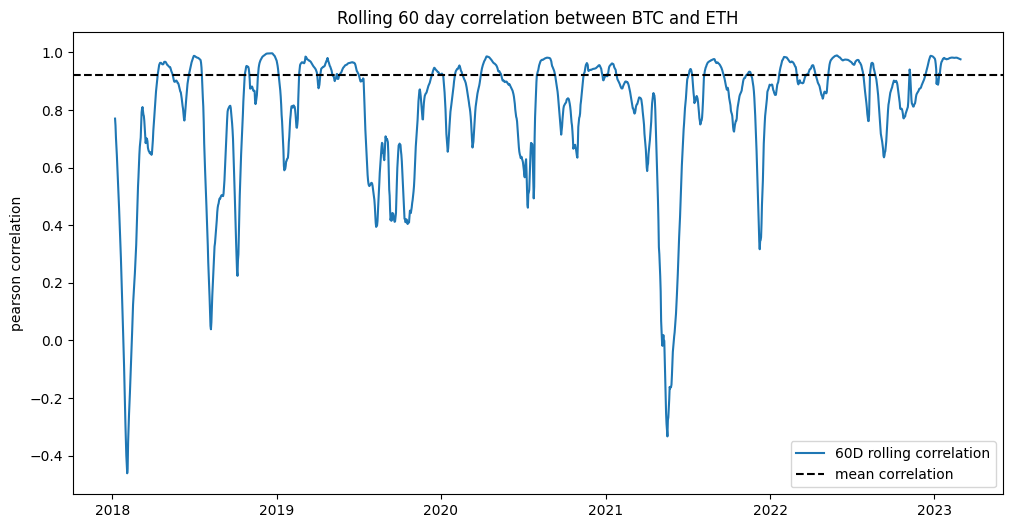

In [24]:
plt.figure(figsize=(12,6))
plt.plot(corr_btc_eth_60d_roll, label='60D rolling correlation')
plt.axhline(corr_btc_eth_mean, color='black', ls='--', label='mean correlation')

plt.title("Rolling 60 day correlation between BTC and ETH")
plt.ylabel("pearson correlation")
plt.legend()

## Descriptive Stats
N, min value, 1st quantile, median, mean, standard deviation, 3rd quantile, max value, skewness, kurtosis

In [25]:
pd.options.display.max_columns = 100

In [75]:
df_close_all_assets = pd.concat([df_asset['Close'].rename(f"Close_{asset_name}") for asset_name, df_asset in dict_assets.items()], axis=1)

df_descriptive_stats = pd.concat([
    df_close_all_assets.describe(), 
    pd.DataFrame(df_close_all_assets.kurtosis(), columns=['kurtosis']).T,
    pd.DataFrame(df_close_all_assets.skew(), columns=['skewness']).T,
])
df_descriptive_stats

,Close_ETH-USD,Close_BTC-USD,Close_XRP-USD,Close_LTC-USD
count,1938.000000,2981.000000,1938.000000,2981.000000
mean,1142.440624,13481.524369,0.520195,69.656052
std,1172.103874,16181.118403,0.359689,66.984527
min,84.308296,178.102997,0.139635,1.157010
25%,213.643108,920.382019,0.288724,4.219910
50%,559.634278,7556.237793,0.388867,54.807610
75%,1718.111817,19044.107422,0.656891,100.378006
max,4812.087402,67566.828125,3.377810,386.450775
kurtosis,0.361284,1.130637,9.853790,1.653547
skewness,1.179694,1.472561,2.419911,1.291831


# Regression

In [11]:
df_asset = dict_assets['BTC-USD']

In [12]:
TARGET = 'daily_log_returns'

In [13]:
FEATURES_LIST_HAND_PICKED = [
    'Close', 'daily_volatility',
    'monthly_realized_volatility', 'weekly_realized_volatility',
    'relative_price_range', 'money_flow_index',
    'avg_directional_movement_index', 'williams_accumulation_distribution',
    'on_balance_volume', 'pma_10', 'pma_30', 'pma_60',
    
    'S_P_500_index_Close', #'S_P_500_index_monthly_realized_volatility', 
    'S_P_500_index_daily_log_returns',

    '^N225_Close', '^IXIC_Close', 'EURUSD=X_Close', '^VIX_Close', '^RUT_Close',

    'Tcm1mo', 'Tcm1yr', 'Tcm5yr', 'Tcm10yr',

    'F-F_Research_Data_5_Factors_Mkt-RF', 'F-F_Research_Data_5_Factors_SMB',
    'F-F_Research_Data_5_Factors_HML', 'F-F_Research_Data_5_Factors_RMW',
    'F-F_Research_Data_5_Factors_CMA', 'F-F_Research_Data_5_Factors_RF',

    ## F-F3 are subset of F-F5
    # 'F-F_Research_Data_3_Factors_Mkt-RF', 'F-F_Research_Data_3_Factors_SMB', 
    # 'F-F_Research_Data_3_Factors_HML', 'F-F_Research_Data_3_Factors_RF',
]

len(FEATURES_LIST_HAND_PICKED)

29

<Axes: >

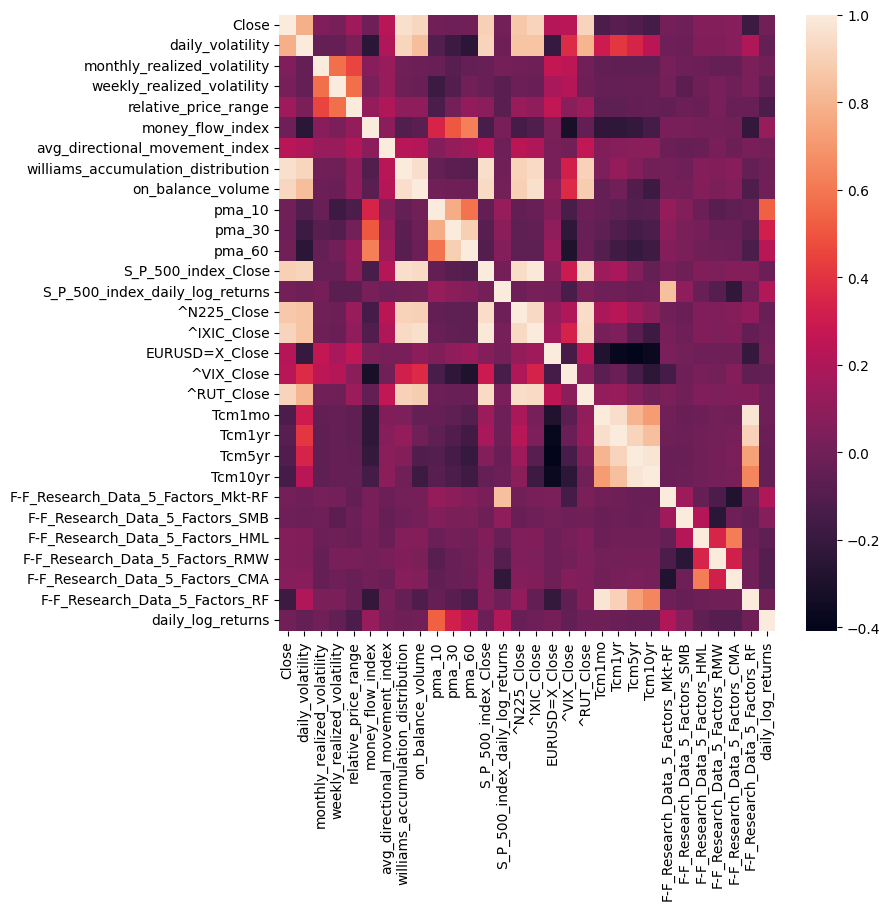

In [14]:
corr = df_asset[FEATURES_LIST_HAND_PICKED+[TARGET]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    # annot=corr.values,
    ax=plt.gca(),
    # vmin=0,
)

In [15]:
TRAIN_DATE_RANGE = ("2018-01-01", "2021-12-31")
TEST_DATE_RANGE = ("2022-01-01", "2022-12-31")

In [16]:
def train_test_split(df_asset, TRAIN_DATE_RANGE, TEST_DATE_RANGE, FEATURES_LIST, TARGET, norm=False):
    
    df_asset_tts = df_asset.copy()
    df_asset_tts[TARGET] = df_asset_tts[TARGET].shift(periods=1)
    df_asset_tts = df_asset_tts[FEATURES_LIST + [TARGET]]
    print(f"{df_asset_tts.shape=}")
    if norm:
        scaler = StandardScaler()
        df_asset_tts[FEATURES_LIST] = scaler.fit_transform(df_asset_tts[FEATURES_LIST])
        with open("./assets/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
    
    df_asset_train = df_asset_tts[TRAIN_DATE_RANGE[0]: TRAIN_DATE_RANGE[1]]
    df_asset_test = df_asset_tts[TEST_DATE_RANGE[0]: TEST_DATE_RANGE[1]]
    
    X_train, Y_train = df_asset_train[FEATURES_LIST], df_asset_train[TARGET]
    X_test, Y_test = df_asset_test[FEATURES_LIST], df_asset_test[TARGET]

    print(f"{X_train.shape=}, {Y_train.shape=}, {X_test.shape=}, {Y_test.shape=}")

    return X_train, Y_train, X_test, Y_test

In [17]:
X_train, Y_train, X_test, Y_test = train_test_split(
    df_asset=df_asset, 
    TRAIN_DATE_RANGE=TRAIN_DATE_RANGE, 
    TEST_DATE_RANGE=TEST_DATE_RANGE, 
    FEATURES_LIST=FEATURES_LIST_HAND_PICKED, 
    TARGET=TARGET, 
    norm=False,
    )

df_asset_tts.shape=(2981, 30)
X_train.shape=(1461, 29), Y_train.shape=(1461,), X_test.shape=(365, 29), Y_test.shape=(365,)


In [18]:
X_train.describe()

,Close,daily_volatility,monthly_realized_volatility,weekly_realized_volatility,relative_price_range,money_flow_index,avg_directional_movement_index,williams_accumulation_distribution,on_balance_volume,pma_10,...,Tcm1mo,Tcm1yr,Tcm5yr,Tcm10yr,F-F_Research_Data_5_Factors_Mkt-RF,F-F_Research_Data_5_Factors_SMB,F-F_Research_Data_5_Factors_HML,F-F_Research_Data_5_Factors_RMW,F-F_Research_Data_5_Factors_CMA,F-F_Research_Data_5_Factors_RF
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1.461000e+03,1461.000000,...,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,18375.242011,5780.942251,0.050231,0.011434,0.049900,52.383831,0.958797,30631.816191,8.953267e+11,1.004735,...,0.010897,0.012150,0.015235,0.018465,0.081629,-0.000589,-0.013018,0.016324,0.002977,0.004297
std,17760.299775,3617.367291,0.049663,0.019013,0.039396,2.115826,0.052040,26899.916954,7.570834e+11,0.067867,...,0.009698,0.010448,0.009371,0.008117,1.313268,0.756930,1.022294,0.517713,0.418757,0.003937
min,3236.761719,2909.620607,0.003623,0.000024,0.004611,48.591295,0.697569,9086.484633,8.946056e+10,0.610077,...,0.000000,0.000400,0.001900,0.005200,-12.000000,-4.550000,-5.000000,-1.870000,-2.260000,0.000000
25%,7116.804199,3826.496687,0.022477,0.003273,0.024123,50.624529,0.941723,12958.157979,1.951241e+11,0.969754,...,0.000700,0.001200,0.007100,0.012500,-0.410000,-0.440000,-0.500000,-0.320000,-0.250000,0.000000
50%,9475.277344,3991.343328,0.034774,0.006911,0.040266,52.181503,0.979842,17179.376229,6.087130e+11,1.004452,...,0.014800,0.015400,0.014400,0.016800,0.130000,-0.040000,-0.090000,0.010000,-0.020000,0.006000
75%,29001.720703,4840.610266,0.059506,0.013417,0.061445,53.506543,0.995065,43423.535398,1.683672e+12,1.040481,...,0.020100,0.023000,0.025100,0.027100,0.700000,0.400000,0.440000,0.300000,0.220000,0.008000
max,67566.828125,15892.528466,0.312928,0.242659,0.479889,60.529573,0.999992,105875.576406,2.687268e+12,1.242924,...,0.025100,0.027400,0.030900,0.032400,9.340000,5.710000,6.740000,2.300000,2.460000,0.011000


## Fit and Score Regression Models

### ARIMA (Not working)

In [49]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

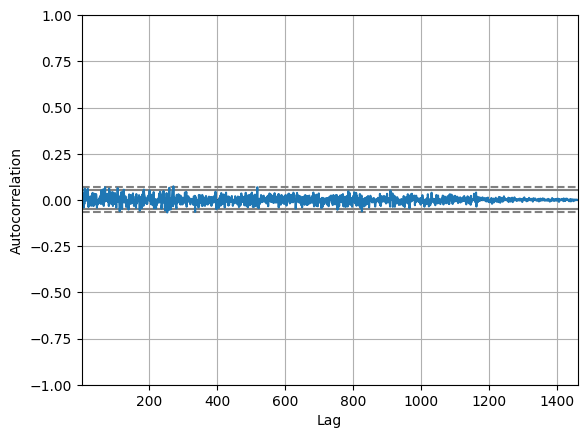

In [48]:
autocorrelation_plot(Y_train)

In [70]:
model_arima = ARIMA(endog=Y_train, exog=X_train, order=(0,1,7))

                               SARIMAX Results                                
Dep. Variable:      daily_log_returns   No. Observations:                 1461
Model:                 ARIMA(0, 1, 7)   Log Likelihood                2786.745
Date:                Tue, 11 Apr 2023   AIC                          -5499.491
Time:                        23:53:12   BIC                          -5303.902
Sample:                    01-01-2017   HQIC                         -5426.528
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Close                                 -0.6285      0.104     -6.046      0.000      -0.832      -0.425
daily_volatility                      -1.1212      0.239   

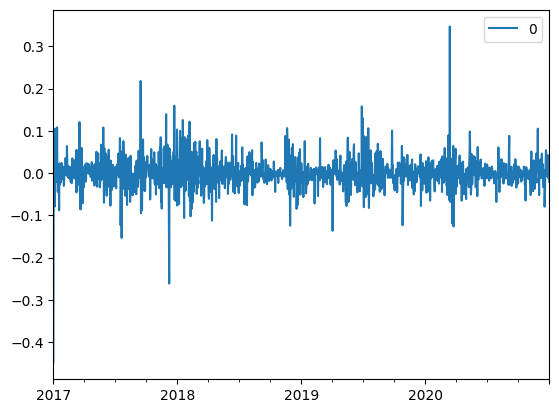

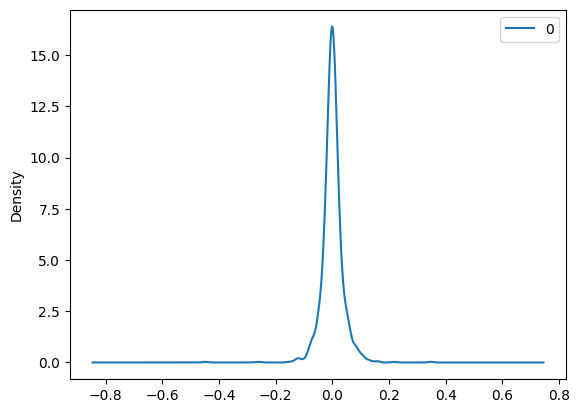

                 0
count  1461.000000
mean      0.000343
std       0.037755
min      -0.448363
25%      -0.015641
50%      -0.000436
75%       0.015390
max       0.346972


In [71]:
model_fit = model_arima.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [74]:
Y_pred_ARIMA = model_fit.forecast(exog=X_test, steps=X_test.shape[0])

In [75]:
r2_score(Y_test, Y_pred_ARIMA)

-95948080.25930463

### Regressions

**Random Forest Regression**

In [ ]:
# Grid-Search for Best Parameters
"""
PARAMS_GS_RFR = {
    "n_estimators": [100, 1000, 5000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

rfr = RandomForestReg({})
rfr.grid_search_CV(
    X_train=X_train, 
    Y_train=Y_train,
    param_grid=PARAMS_GS_RFR,
    cv=None, 
    refit=True,
    scoring='r2', 
    n_jobs=-1, 
    verbose=5,
)
"""

In [19]:
PARAMS_RFR = {
    "n_estimators": 1000,
    "criterion": "squared_error",
    "max_depth": None,
    "max_features": None,
    "min_samples_leaf": 1,
}

rfr = RandomForestReg(**PARAMS_RFR)
rfr.fit_regressor(X_train, Y_train)
Y_pred = rfr.predict_regressor(X_test)
rfr.score_regressor(X_test, Y_test)

<Axes: xlabel='importance_score', ylabel='feature'>

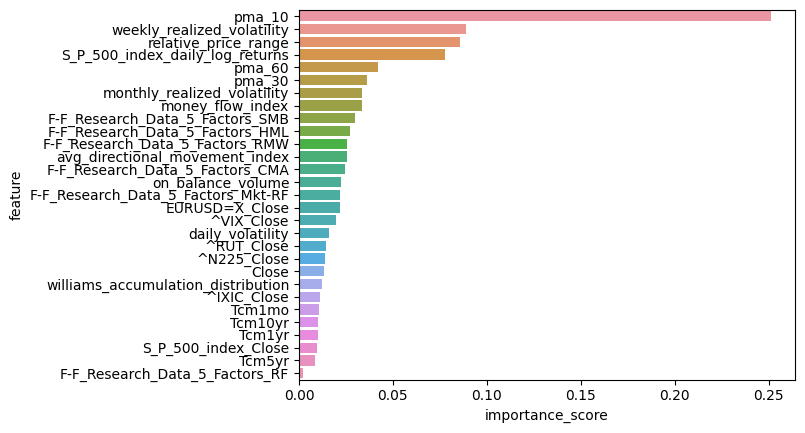

In [20]:
df_feat_imp = pd.DataFrame(
    [X_train.columns, rfr.regressor.feature_importances_], 
    index=["feature", "importance_score"]
    ).T.sort_values(by="importance_score", ascending=False)
sns.barplot(x=df_feat_imp["importance_score"], y=df_feat_imp["feature"], orient="horizonal")

**Histogram Gradient Boosting Regressor**

In [21]:
PARAMS_HGBR = {
    "loss": "squared_error",
    "max_depth": None,
    "validation_fraction": 0.2,
}

hgbr = HistGradientBoostingReg(**PARAMS_HGBR)
hgbr.fit_regressor(X_train, Y_train)
Y_pred = hgbr.predict_regressor(X_test)
hgbr.score_regressor(X_test, Y_test)

**Stochastic Gradient Descent Regressor**

In [81]:
PARAMS_SGDR = {
    "loss": "squared_error",#"squared_error",
    "max_iter": 100,
    "penalty": "l2",
    "validation_fraction": 0.2,
    "early_stopping": True,
    "n_iter_no_change": 10,
    "learning_rate": "optimal",
}

sgdr = SGDReg(scaler="StandardScaler", **PARAMS_SGDR)
sgdr.fit_regressor(X_train, Y_train)
Y_pred = sgdr.predict_regressor(X_test)
sgdr.score_regressor(X_test, Y_test)

**Elastic Net Regressor**

In [24]:
PARAMS_ENR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

enr = ElasticNetReg(**PARAMS_ENR)
enr.fit_regressor(X_train, Y_train)
Y_pred = enr.predict_regressor(X_test)
enr.score_regressor(X_test, Y_test)

**ThielSen Regressor**

In [25]:
PARAMS_TSR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

tsr = TheilSenReg(**PARAMS_TSR)
tsr.fit_regressor(X_train, Y_train)
Y_pred = tsr.predict_regressor(X_test)
tsr.score_regressor(X_test, Y_test)

**RANSAC Regressor**

In [26]:
PARAMS_RANSACR = {
    # "loss": "squared_error",
    # "max_depth": None,
    # "validation_fraction": 0.2,
}

ransacr = RANSACReg(**PARAMS_RANSACR)
ransacr.fit_regressor(X_train, Y_train)
Y_pred = ransacr.predict_regressor(X_test)
ransacr.score_regressor(X_test, Y_test)

## Plot Prediction

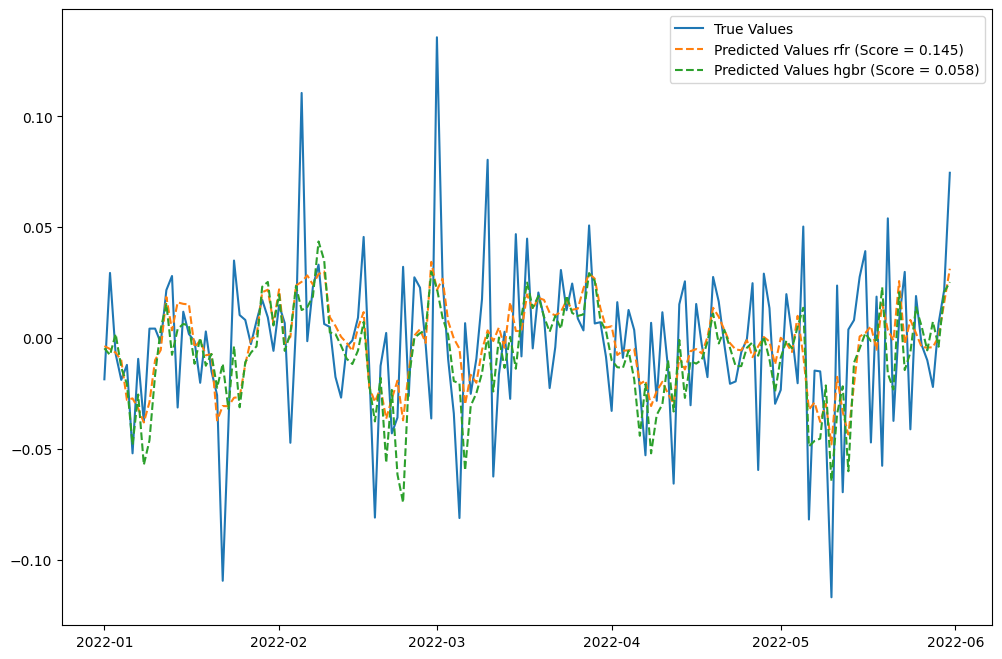

In [22]:
## Rest of the models are not good :(\
## But the problem is idk the theory there, so IDK how to make them better (even if possible in the first place)

dict_regressors = {
    "rfr": rfr, 
    "hgbr": hgbr, 
    # "sgdr": sgdr, 
    # "enr": enr, 
    # "tsr": tsr, 
    # "ransacr": ransacr,
}

plt.figure(figsize=(12, 8))

PLOT_RANGE = ("2022-01-01", "2022-05-31")

plt.plot(Y_test[PLOT_RANGE[0]: PLOT_RANGE[1]], label="True Values")

for regressor_name, regressor in dict_regressors.items():
    # if regressor_name=='sgdr':
    #     continue
    plt.plot(
        regressor.Y_pred[PLOT_RANGE[0]: PLOT_RANGE[1]],
        label=f"Predicted Values {regressor_name} (Score = {round(regressor.score, 3)})",
        ls='--',
    )

# plt.plot(
#     Y_pred_ARIMA[PLOT_RANGE[0]: PLOT_RANGE[1]],
#     label=f"Predicted Values ARIMA (Score = {r2_score(Y_test, Y_pred_ARIMA)})",
#     ls='--'
#     )
# plt.title(f"Score= {round(rfr.score, 3)}")

plt.legend()
plt.show()

# Trading Strategy

In [23]:
Close_n_1 = X_train['Close'].iloc[-1]
arr_close = np.array([np.nan]*len(X_test))

for i in range(len(X_test)):
    arr_close[i] = Close_n_1 * np.exp(rfr.Y_pred.iloc[i])
    Close_n_1 = arr_close[i]

ds_close_pred = pd.Series(arr_close, index=rfr.Y_pred.index)

In [24]:
rfr_trading_strategy = TradingStrategy(rfr.Y_pred, ds_close_pred)

In [26]:
true_ts = TradingStrategy(Y_test, X_test['Close'])

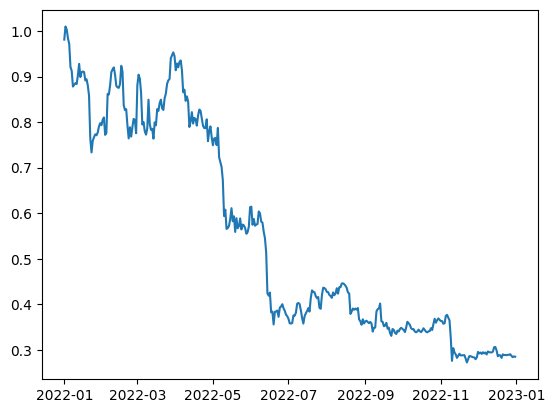

In [27]:
rfr_baseline = rfr_trading_strategy.strategy_buy_and_hold()
plt.plot(true_ts.strategy_buy_and_hold())
# plt.plot(df_rfr_payoffs['payoff_SMA_7'])
# ax2 = plt.twinx()
# ax2.plot(true_ts.strategy_buy_and_hold() - rfr_baseline, color='red')
plt.show()

In [26]:
list_strategies = [
    'SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 
    'EMA_7', 'EMA_30', 'EMA_90', 'EMA_180', 
    'BBS_7', 'BBS_14', 'BBS_30', 
    'RSI_7', 'RSI_14', 'RSI_30'
    ]

df_rfr_payoffs = rfr_trading_strategy.apply_strategy(list_strategies, return_payoff=True)

In [29]:
df_rfr_payoffs#[[col for col in df_rfr_payoffs.columns if col.startswith("signal")]]

,signal_SMA_7,payoff_SMA_7,signal_SMA_30,payoff_SMA_30,signal_SMA_90,payoff_SMA_90,signal_SMA_180,payoff_SMA_180,signal_EMA_7,payoff_EMA_7,...,signal_BBS_14,payoff_BBS_14,signal_BBS_30,payoff_BBS_30,signal_RSI_7,payoff_RSI_7,signal_RSI_14,payoff_RSI_14,signal_RSI_30,payoff_RSI_30
2022-01-01,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000,...,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000
2022-01-02,0,1.000000,0,1.000000,0,1.000000,0,1.000000,-1,1.004971,...,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000
2022-01-03,0,1.000000,0,1.000000,0,1.000000,0,1.000000,-1,1.011624,...,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000
2022-01-04,0,1.000000,0,1.000000,0,1.000000,0,1.000000,-1,1.021813,...,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000
2022-01-05,0,1.000000,0,1.000000,0,1.000000,0,1.000000,-1,1.050388,...,0,1.000000,0,1.000000,0,1.000000,0,1.000000,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-1,37.972900,1,3.410505,-1,1.566945,-1,1.179189,-1,39.967305,...,0,0.225247,0,0.295595,0,0.039697,1,0.215544,-1,0.672014
2022-12-28,-1,38.272180,1,3.383626,-1,1.579295,-1,1.188483,-1,40.282303,...,0,0.225247,0,0.295595,0,0.039697,1,0.213845,-1,0.677310
2022-12-29,-1,38.627199,-1,3.415013,-1,1.593945,-1,1.199507,-1,40.655969,...,0,0.225247,0,0.295595,1,0.039329,1,0.211862,0,0.677310
2022-12-30,-1,38.798776,-1,3.430182,-1,1.601025,-1,1.204835,-1,40.836558,...,0,0.225247,0,0.295595,1,0.039154,1,0.210921,0,0.677310


In [30]:
list_strategies = ['SMA_7', 'SMA_30', 'SMA_90', 'SMA_180', 'EMA_7', 'EMA_30',
                   'EMA_90', 'EMA_180', 'BBS_7', 'BBS_14', 'BBS_30', 'RSI_7', 'RSI_14', 'RSI_30']

df_true_payoffs = true_ts.apply_strategy(list_strategies, return_payoff=True)

In [31]:
df_true_payoffs[[col for col in df_true_payoffs.columns if col.startswith("payoff")]]

,payoff_SMA_7,payoff_SMA_30,payoff_SMA_90,payoff_SMA_180,payoff_EMA_7,payoff_EMA_30,payoff_EMA_90,payoff_EMA_180,payoff_BBS_7,payoff_BBS_14,payoff_BBS_30,payoff_RSI_7,payoff_RSI_14,payoff_RSI_30
2022-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
2022-01-02,1.000000,1.000000,1.000000,1.000000,0.970626,0.970626,0.970626,0.970626,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
2022-01-03,1.000000,1.000000,1.000000,1.000000,0.977604,0.977604,0.977604,0.977604,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
2022-01-04,1.000000,1.000000,1.000000,1.000000,0.996095,0.996095,0.996095,0.996095,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
2022-01-05,1.000000,1.000000,1.000000,1.000000,1.008187,1.008187,1.008187,1.008187,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,39.805308,12.448777,3.496213,1.108377,48.025561,14.367316,4.592462,3.553793,0.932949,0.264178,0.31155,0.046931,0.228331,0.999874
2022-12-28,40.284893,12.598763,3.538337,1.121731,48.604185,14.540417,4.647793,3.596610,0.932949,0.264178,0.31155,0.046366,0.228331,0.999874
2022-12-29,40.683514,12.723429,3.573349,1.132830,49.085126,14.684295,4.693783,3.632198,0.932949,0.264178,0.31155,0.046366,0.228331,0.999874
2022-12-30,40.463471,12.654612,3.554022,1.126703,48.819642,14.604873,4.668396,3.612553,0.932949,0.264178,0.31155,0.046616,0.228331,0.999874


# Performance

In [35]:
true_daily_log_returns = Y_test


perf_m = PerformanceMetrics(
    true_daily_log_returns, 
    df_rfr_payoffs[[col for col in df_rfr_payoffs.columns if col.startswith("signal")]],
    )

In [55]:
performance_metrics = [
    'cumulative_return', 'annualized_return', 'average_daily_log_returns', 
    'annualized_volatility', 'sharpe_ratio', 'annualized_sharpe_ratio', 
    'sortino_ratio', 'max_drawdown', 'calmar_ratio',
    ]

perf_m.compute_performance_metrics(performance_metrics)

,signal_SMA_7,signal_SMA_30,signal_SMA_90,signal_SMA_180,signal_EMA_7,signal_EMA_30,signal_EMA_90,signal_EMA_180,signal_BBS_7,signal_BBS_14,signal_BBS_30,signal_RSI_7,signal_RSI_14,signal_RSI_30
cumulative_return,4.025988,0.547659,0.152708,0.161528,7.239829,1.860667,1.25747,1.563226,-0.319053,-0.712785,-0.372172,-0.841252,-0.487058,-0.275432
annualized_return,4.025988,0.547659,0.152708,0.161528,7.239829,1.860667,1.25747,1.563226,-0.319053,-0.712785,-0.372172,-0.841252,-0.487058,-0.275432
average_daily_log_returns,0.004969,0.001724,0.000803,0.000625,0.006328,0.003437,0.002789,0.003138,-0.001018,-0.003199,-0.001161,-0.004518,-0.001493,-0.000687
annualized_volatility,0.634052,0.623934,0.55356,0.398959,0.632957,0.641064,0.642215,0.641627,0.155559,0.382098,0.284719,0.600519,0.490102,0.376023
sharpe_ratio,0.14971,0.052777,0.027726,0.029927,0.190992,0.102443,0.082982,0.093428,-0.124979,-0.159963,-0.077891,-0.143743,-0.05818,-0.034927
annualized_sharpe_ratio,2.860198,1.008294,0.529713,0.571747,3.648892,1.957169,1.585378,1.784943,-2.387725,-3.056098,-1.488099,-2.746213,-1.111532,-0.667273
sortino_ratio,0.268133,0.07803,0.0393,0.042442,0.345865,0.159528,0.128299,0.140034,-0.126967,-0.169691,-0.090398,-0.15483,-0.068193,-0.043867
max_drawdown,1.586245,1.780019,1.609165,1.658775,1.586245,1.780019,1.780019,1.780019,3.982368,2.705772,2.147177,2.705772,2.28202,2.160568
calmar_ratio,2.538062,0.30767,0.094899,0.097378,4.564131,1.045308,0.706436,0.878207,-0.080116,-0.263431,-0.173331,-0.31091,-0.213433,-0.127481
